In [7]:
from collections import Counter
from gensim.corpora import Dictionary
from nltk import ngrams
from scipy import stats

import itertools
import numpy as np
import os
import pybo

import matplotlib.pyplot as plt
%matplotlib inline

Store texts in the following directory structure:

    texts
      Bon
        file1.txt
        file2.txt
        ...
      Nyingma
        file1.txt
        file2.txt
        ...

In [8]:
tok = pybo.BoTokenizer('POS')

Loading Trie...
Time: 4.9362452030181885


Assumptions here:
1. Drop all non-bo text
2. Drop all phrase delimiters (shad)
3. Reduce words to lemmas
4. Strip beginning and ending tseks from lemmas

In [104]:
tsek = '་'
filter_list = ['གི','ལ','གིས','དང','ནི','ནས','པ','གོ','ཀྱང','དུ','ཀྱིས','དེ','ཏེ','མ','སྟེ','སུ','ཀྱི','གྱིས','ན','ཅེས','འདི','གྱི','ཅི','བ','པར','ཡིས','ཅིང','མོ','ཅེས་པ','རྣམས','ཏུ']

def read_texts(text_dir):
    fnames = []
    texts = []
    texts_f = []
    bigrams = []
    bigrams_f = []
    texts_bigrams = []
    texts_bigrams_f = []
    
    for filename in sorted(os.listdir(text_dir)):
        if ".txt" in filename:
            with open(os.path.join(text_dir, filename), 'r', encoding='utf-8-sig') as f:
                fnames.append(filename)
                tokens = [t for t in tok.tokenize(f.read()) if t.type != "non-bo" and t.pos != "punct"]
                
                lemmas = [t.lemma.strip(tsek) if t.lemma else t.content.strip(tsek) for t in tokens]
                texts.append(lemmas)
                
                lemmas_f = [l for l in lemmas if l not in filter_list]
                texts_f.append(lemmas_f)
                
                grams = [tsek.join(x) for x in ngrams(lemmas, 2)]
                bigrams.append(grams)
                
                grams_f = [tsek.join(x) for x in ngrams(lemmas, 2) if not set(x).intersection(filter_list)]
                bigrams_f.append(grams_f)
                
                texts_bigrams.append(lemmas + grams)
                texts_bigrams_f.append(lemmas_f + grams_f)
            
    return texts, texts_f, bigrams, bigrams_f, texts_bigrams, texts_bigrams_f, fnames

In [105]:
def vectorize_texts(texts, dct):
    vecs = []
    for t in texts:
        vec = np.zeros(len(dct))
        bow = dct.doc2bow(t)
        for k, v in bow:
            vec[k] = v
        vecs.append(vec)
    return vecs

In [87]:
def cos_sim(u, v):
    return (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

def plot_all(c1, c2, c1_files, c2_files, k, c1_name, c2_name):
    # 1st plot
    X = np.zeros((len(c1), len(c1)))
    
    for i in range(len(c1)):
        for j in range(len(c1)):
            u = c1[i]
            v = c1[j]
            X[i,j] = k(u, v)
            
    # Set axes
    figs, axs = plt.subplots(figsize=(10,10))
    axs.pcolor(X, cmap="hot")
    axs.set_aspect('equal')

    # put the major ticks at the middle of each cell
    axs.set_xticks(np.arange(X.shape[1]) + 0.5, minor=False)
    axs.set_yticks(np.arange(X.shape[0]) + 0.5, minor=False)

    # want a more natural, table-like display
    axs.invert_yaxis()
    axs.xaxis.tick_top()

    axs.set_xticklabels(c1_files, minor=False)
    axs.set_yticklabels(c1_files, minor=False)
    
    for label in axs.get_xmajorticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("left")
    
    plt.show()
    print("{} intra class similarity".format(c1_name))
    
    # 2nd plot
    X = np.zeros((len(c2), len(c2)))
    
    for i in range(len(c2)):
        for j in range(len(c2)):
            u = c2[i]
            v = c2[j]
            X[i,j] = k(u, v)
            
    # Set axes
    figs, axs = plt.subplots(figsize=(10,10))
    axs.pcolor(X, cmap="hot")
    axs.set_aspect('equal')

    # put the major ticks at the middle of each cell
    axs.set_xticks(np.arange(X.shape[1]) + 0.5, minor=False)
    axs.set_yticks(np.arange(X.shape[0]) + 0.5, minor=False)

    # want a more natural, table-like display
    axs.invert_yaxis()
    axs.xaxis.tick_top()

    axs.set_xticklabels(c2_files, minor=False)
    axs.set_yticklabels(c2_files, minor=False)
    
    for label in axs.get_xmajorticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("left")
    
    plt.show()
    print("{} intra class similarity".format(c2_name))
    
    # 3rd plot
    X = np.zeros((len(c1), len(c2)))
    
    for i in range(len(c1)):
        for j in range(len(c2)):
            u = c1[i]
            v = c2[j]
            X[i,j] = k(u, v)
            
    # Set axes
    figs, axs = plt.subplots(figsize=(10,10))
    axs.pcolor(X, cmap="hot")
    axs.set_aspect('equal')

    # put the major ticks at the middle of each cell
    axs.set_xticks(np.arange(X.shape[1]) + 0.5, minor=False)
    axs.set_yticks(np.arange(X.shape[0]) + 0.5, minor=False)

    # want a more natural, table-like display
    axs.invert_yaxis()
    axs.xaxis.tick_top()

    axs.set_xticklabels(c2_files, minor=False)
    axs.set_yticklabels(c1_files, minor=False)
    
    for label in axs.get_xmajorticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("left")
    
    plt.show()
    print("{} vs {} inter class similarity".format(c1_name, c2_name))

In [116]:
def run_all(c1_texts, c2_texts, c1_name, c2_name, c1_fnames, c2_fnames):
    dct = Dictionary(c1_texts + c2_texts)
    c1 = vectorize_texts(c1_texts, dct)
    c2 = vectorize_texts(c2_texts, dct)
    plot_all(c1, c2, c1_fnames, c2_fnames, k=cos_sim, c1_name=c1_name, c2_name=c2_name)

In [106]:
bon_texts, bon_texts_f, bon_bigrams, bon_bigrams_f, bon_texts_bigrams, bon_texts_bigrams_f, bon_fnames = read_texts("texts/Bon")
nyingma_texts, nyingma_texts_f, nyingma_bigrams, nyingma_bigrams_f, nyingma_texts_bigrams, nyingma_texts_bigrams_f, nyingma_fnames = read_texts("texts/Nyingma")
news_texts, news_texts_f, news_bigrams, news_bigrams_f, news_texts_bigrams, news_texts_bigrams_f, news_fnames = read_texts("texts/News")
bon_d_texts, bon_d_texts_f, bon_d_bigrams, bon_d_bigrams_f, bon_d_texts_bigrams, bon_d_texts_bigrams_f, bon_d_fnames = read_texts("texts/Bon-dzogchen")
mahamudra_texts, mahamudra_texts_f, mahamudra_bigrams, mahamudra_bigrams_f, mahamudra_texts_bigrams, mahamudra_texts_bigrams_f, mahamudra_fnames = read_texts("texts/Mahamudra")

## Ex: Bon + Bon Dzogchen  + Outgroup vs Nyingma + Bon Dzogchen + Outgroup

### a) Word frequency (unfiltered)

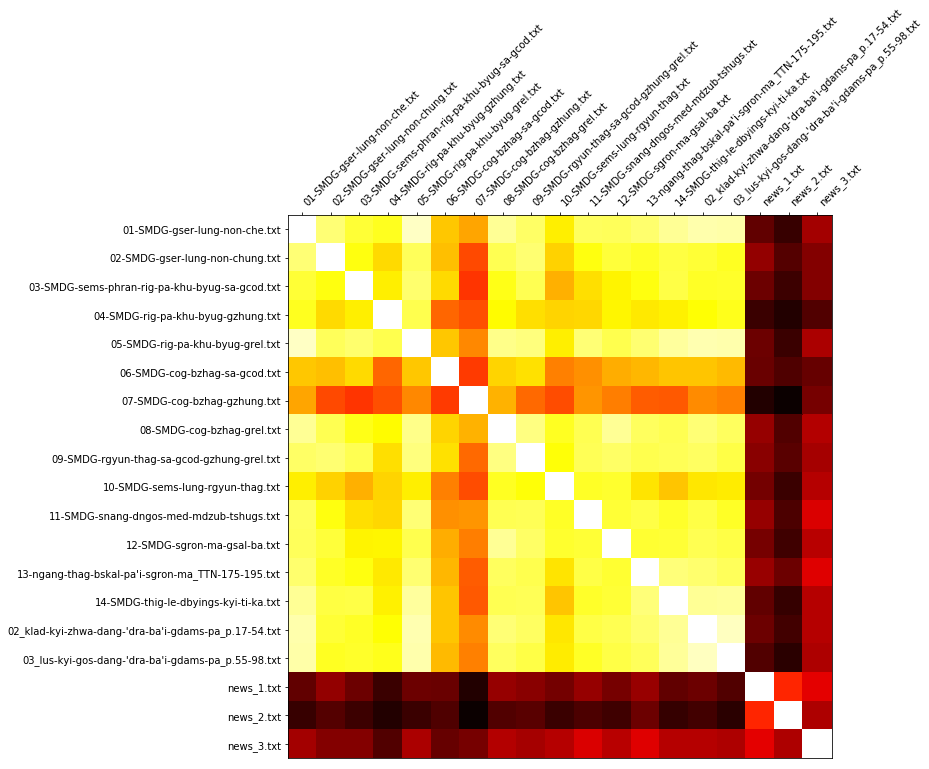

Bon + Bon Dzogchen + News intra class similarity


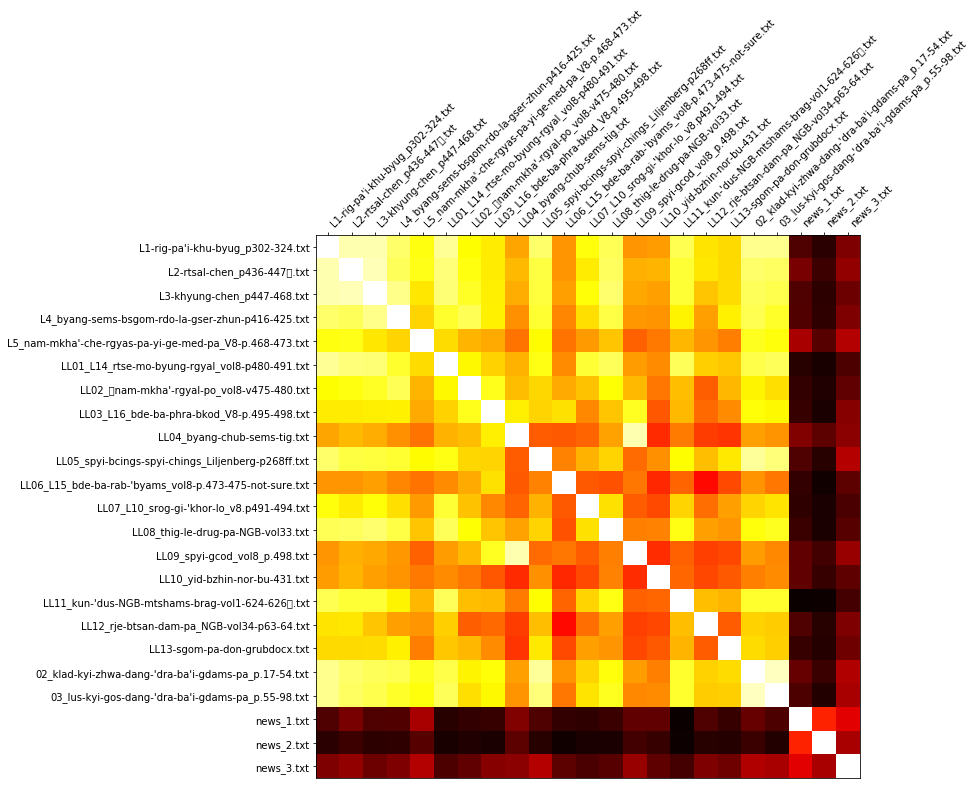

Nyingma + Bon Dzogchen + News intra class similarity


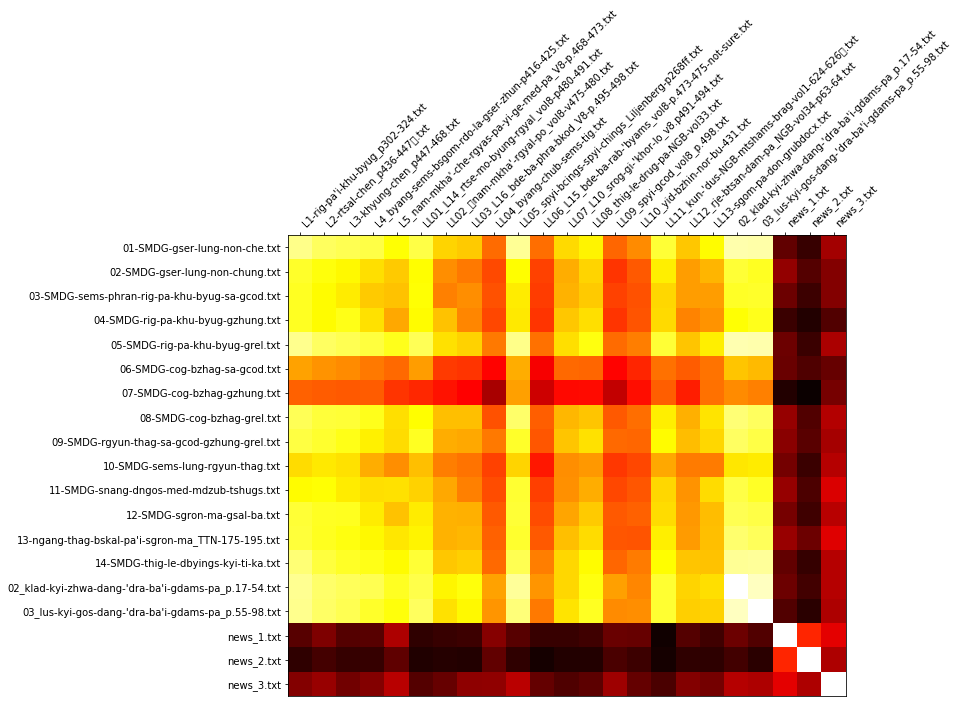

Bon + Bon Dzogchen + News vs Nyingma + Bon Dzogchen + News inter class similarity


In [117]:
run_all(bon_texts + bon_d_texts + news_texts,
        nyingma_texts + bon_d_texts + news_texts,
        "Bon + Bon Dzogchen + News",
        "Nyingma + Bon Dzogchen + News",
        bon_fnames + bon_d_fnames + news_fnames,
        nyingma_fnames + bon_d_fnames + news_fnames)

### b) Word frequency (filtered)

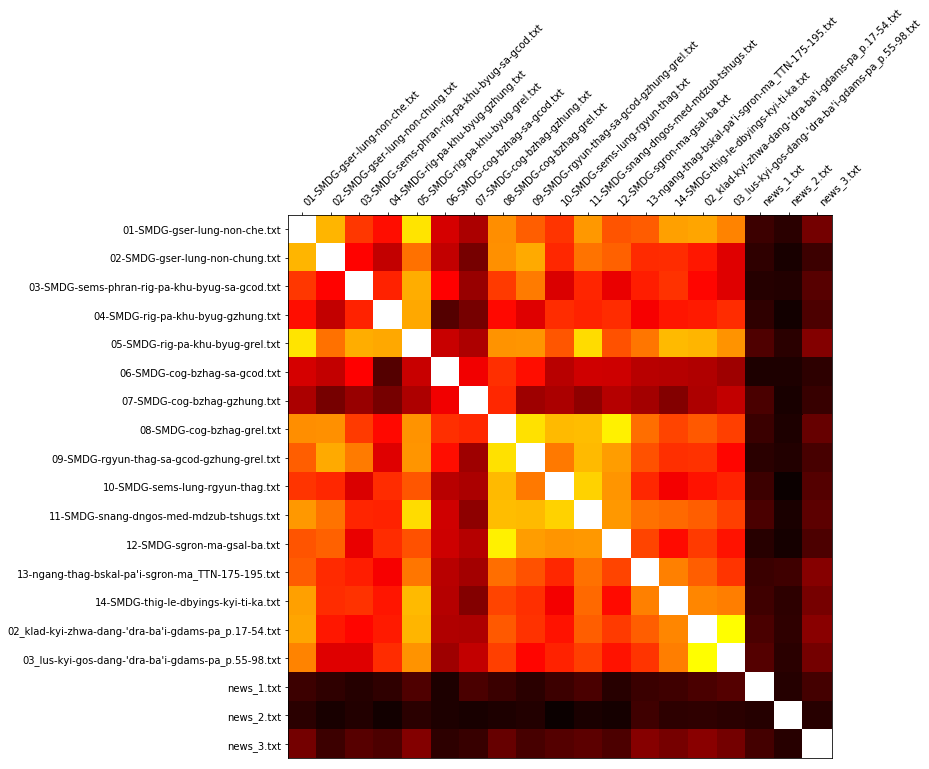

Bon + Bon Dzogchen + News intra class similarity


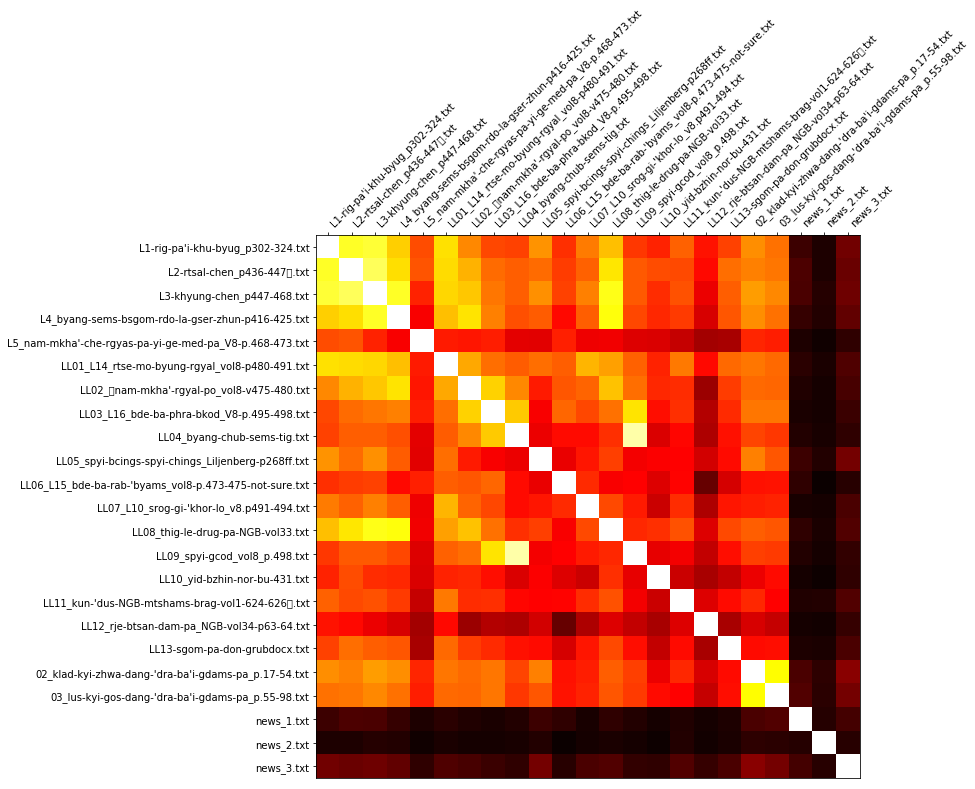

Nyingma + Bon Dzogchen + News intra class similarity


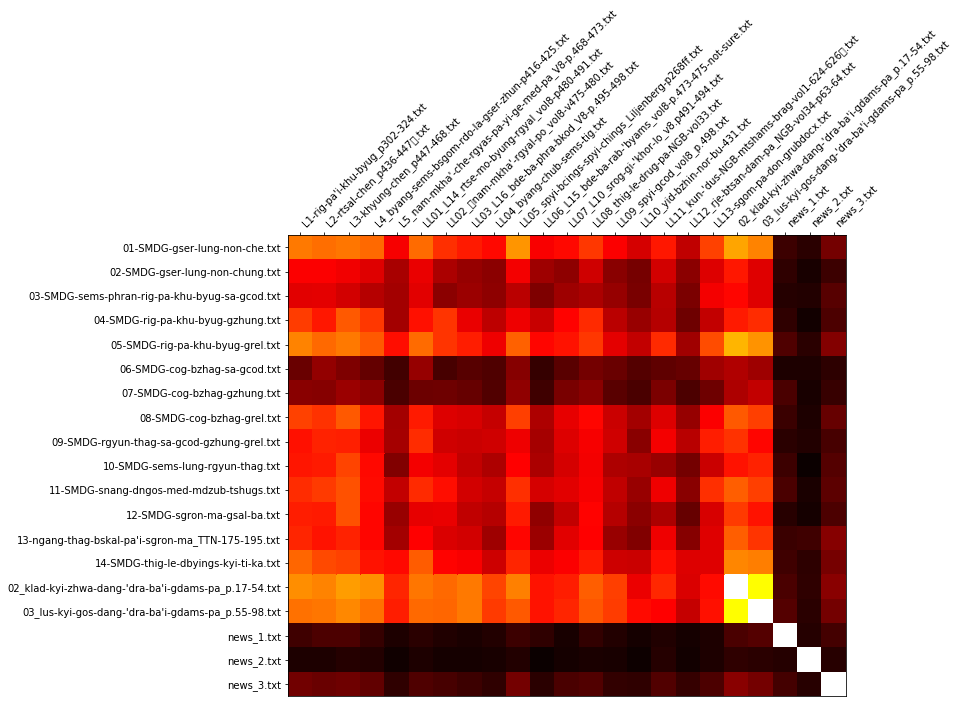

Bon + Bon Dzogchen + News vs Nyingma + Bon Dzogchen + News inter class similarity


In [119]:
run_all(bon_texts_f + bon_d_texts_f + news_texts_f,
        nyingma_texts_f + bon_d_texts_f + news_texts_f,
        "Bon + Bon Dzogchen + News",
        "Nyingma + Bon Dzogchen + News",
        bon_fnames + bon_d_fnames + news_fnames,
        nyingma_fnames + bon_d_fnames + news_fnames)

### c) Bigram frequency (filtered)

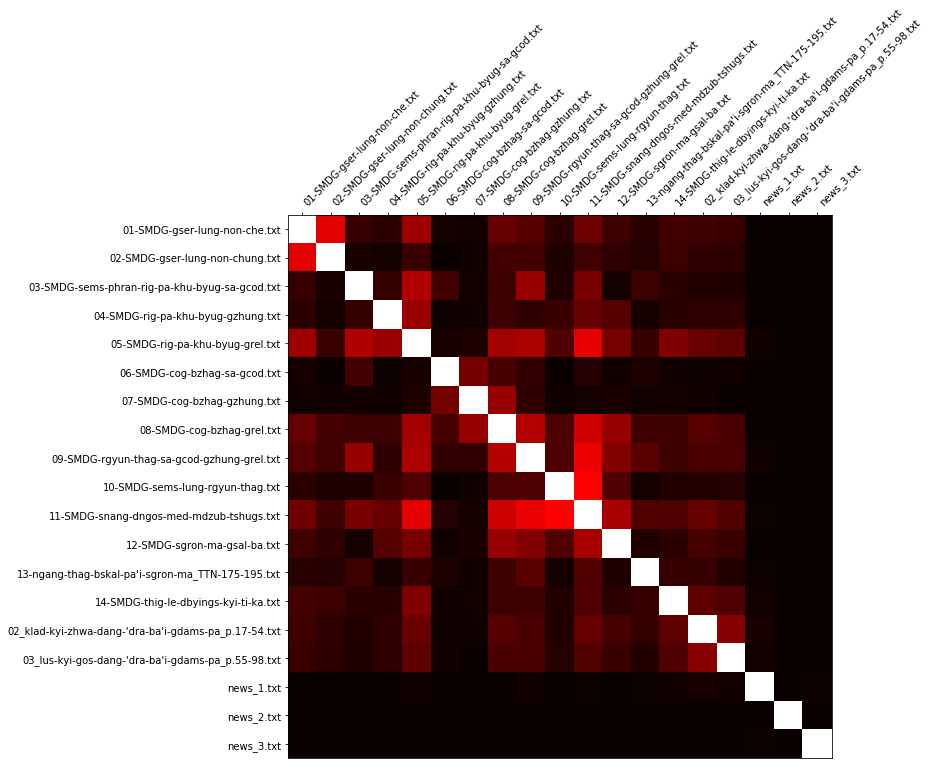

Bon + Bon Dzogchen + News intra class similarity


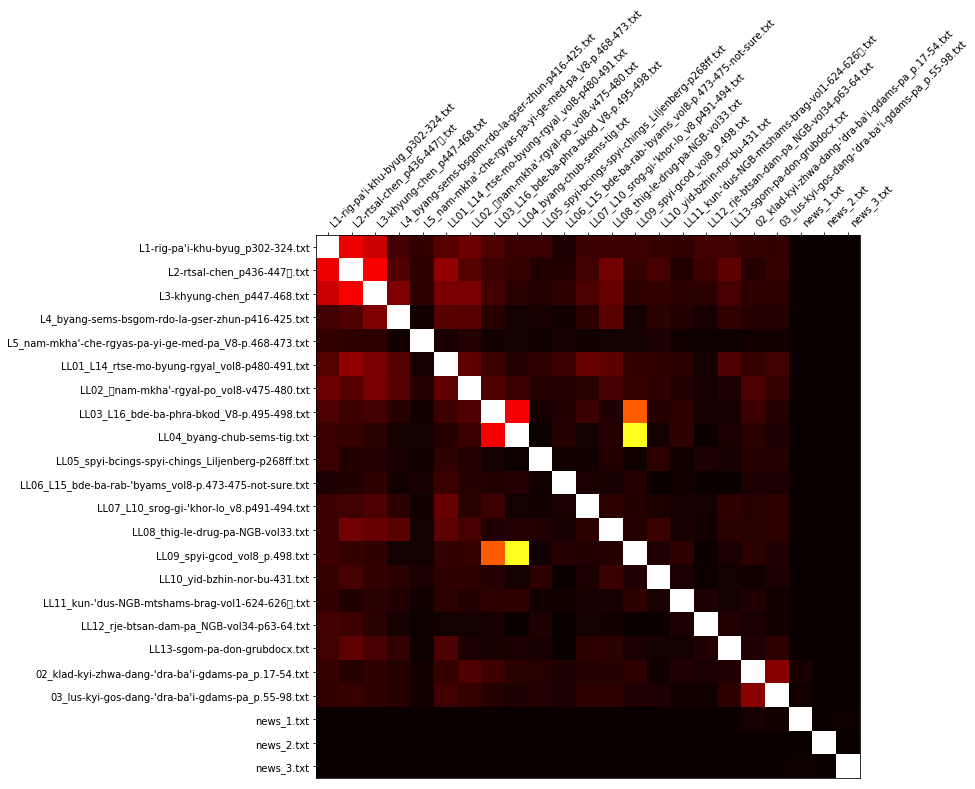

Nyingma + Bon Dzogchen + News intra class similarity


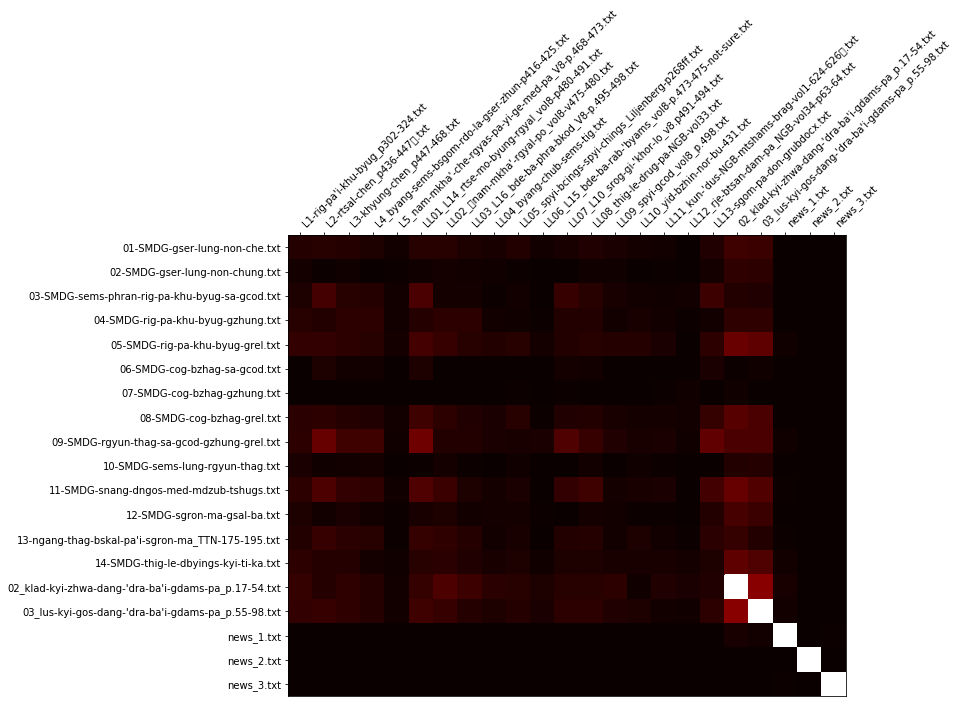

Bon + Bon Dzogchen + News vs Nyingma + Bon Dzogchen + News inter class similarity


In [120]:
run_all(bon_bigrams_f + bon_d_bigrams_f + news_bigrams_f,
        nyingma_bigrams_f + bon_d_bigrams_f + news_bigrams_f,
        "Bon + Bon Dzogchen + News",
        "Nyingma + Bon Dzogchen + News",
        bon_fnames + bon_d_fnames + news_fnames,
        nyingma_fnames + bon_d_fnames + news_fnames)

### d) Word + Bigram frequency (filtered)

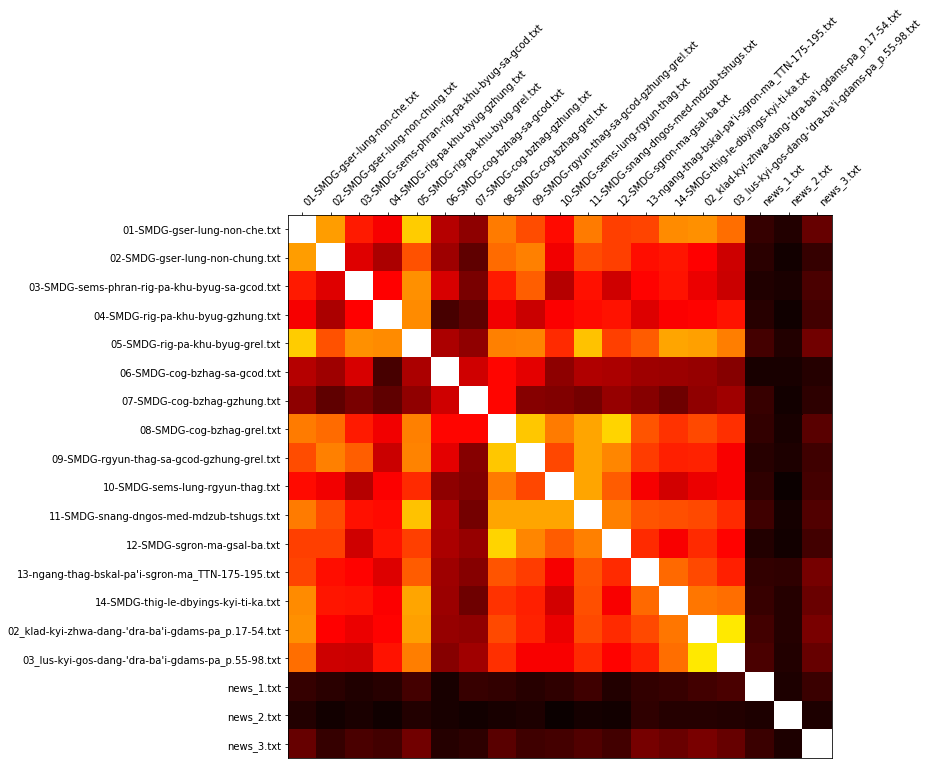

Bon + Bon Dzogchen + News intra class similarity


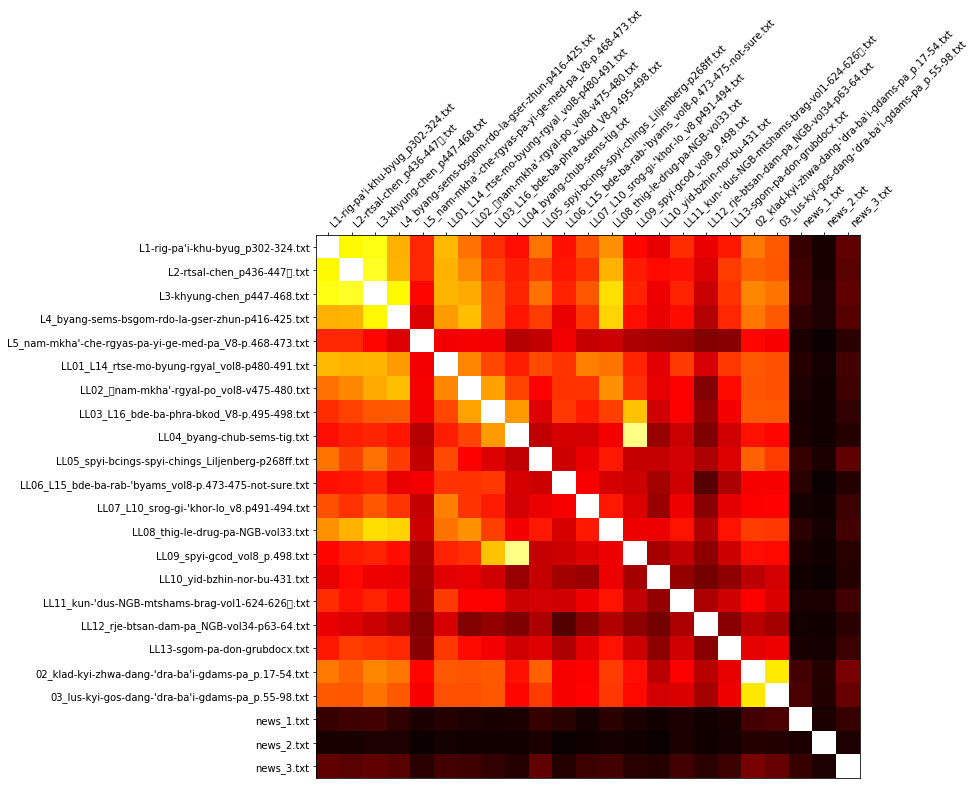

Nyingma + Bon Dzogchen + News intra class similarity


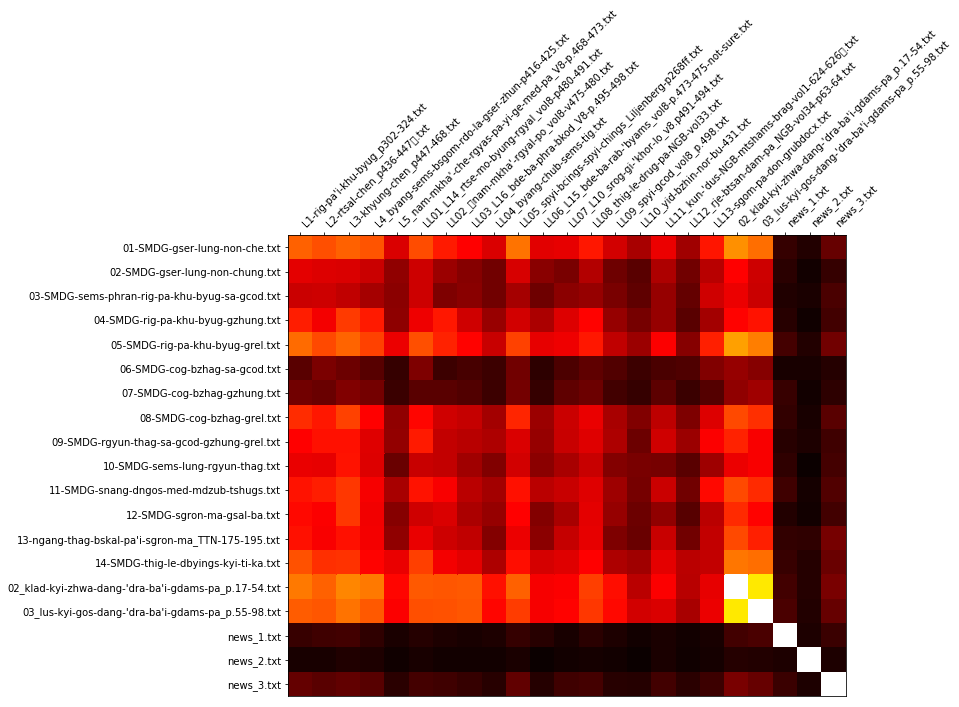

Bon + Bon Dzogchen + News vs Nyingma + Bon Dzogchen + News inter class similarity


In [121]:
run_all(bon_texts_bigrams_f + bon_d_texts_bigrams_f + news_texts_bigrams_f,
        nyingma_texts_bigrams_f + bon_d_texts_bigrams_f + news_texts_bigrams_f,
        "Bon + Bon Dzogchen + News",
        "Nyingma + Bon Dzogchen + News",
        bon_fnames + bon_d_fnames + news_fnames,
        nyingma_fnames + bon_d_fnames + news_fnames)

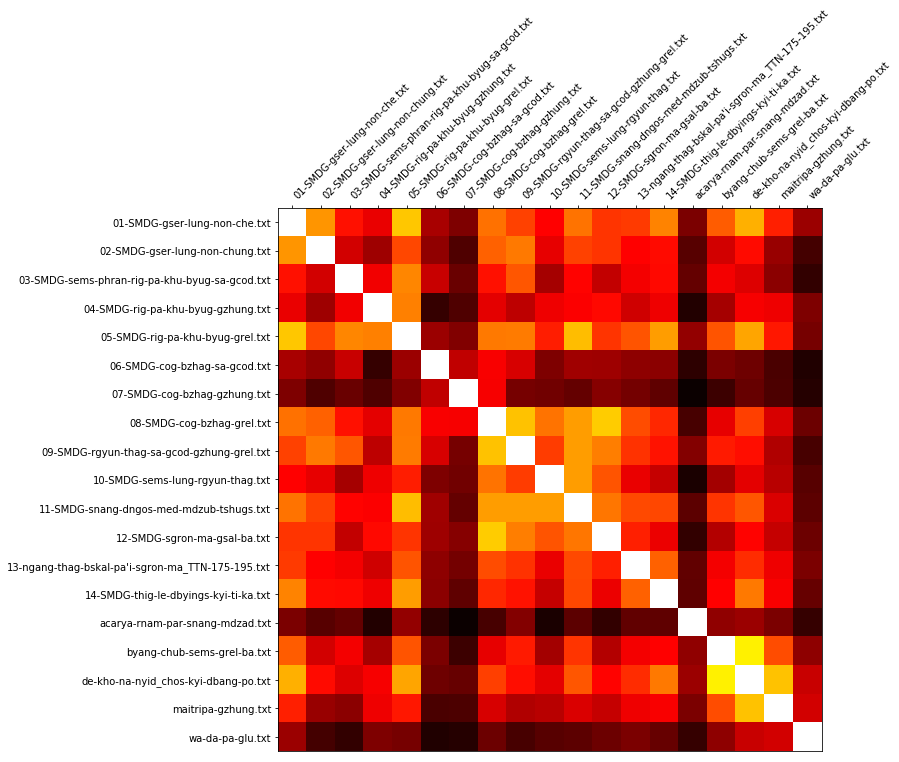

Bon + Mahamudra intra class similarity


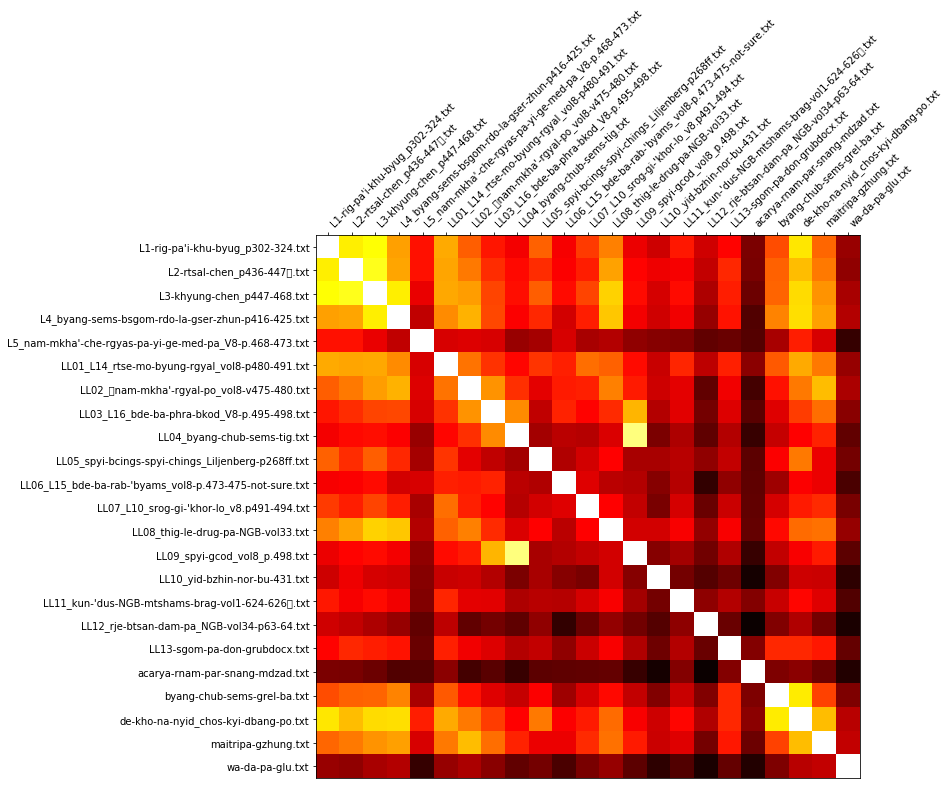

Nyingma + Mahamudra intra class similarity


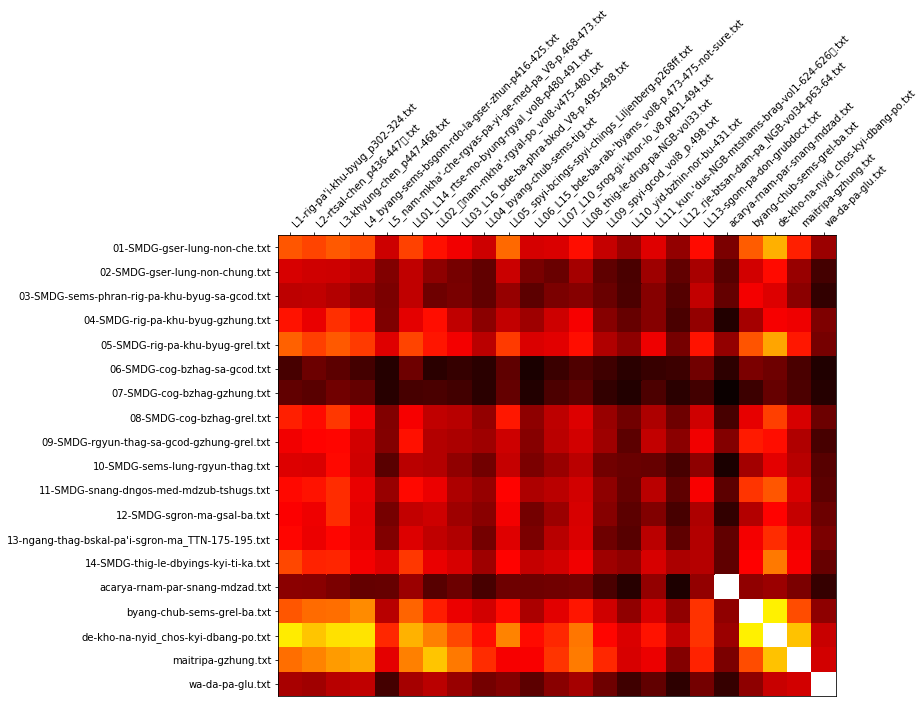

Bon + Mahamudra vs Nyingma + Mahamudra inter class similarity


In [122]:
run_all(bon_texts_bigrams_f + mahamudra_texts_bigrams_f,
        nyingma_texts_bigrams_f + mahamudra_texts_bigrams_f,
        "Bon + Mahamudra",
        "Nyingma + Mahamudra",
        bon_fnames + mahamudra_fnames,
        nyingma_fnames + mahamudra_fnames)